# Embeddings for expanding vocabularies

This notebook demonstrates how to construct embeddings for vocabularies that change incrementally.

A vocabulary is a set of elements that are relevant to a subject domain. For a natural language like English, the word 'vocabulary' is typically used to refer to the set of all words in the language. But the concept is also applicable in other settings. For example, a vocabulary may refer to the set of produce stocked in a shop. A finite vocabulary is useful for data management. However, a vocabulary by itself does not assign meaning to any of its elements, nor does it convey relationships (similarities and dissimilarities) between any of the elements.

An embedding is a mapping of vocabulary elements into a low-dimensional space. The position of the elements in the low-dimensional space is intended to convey semantic meaning. For example, consider mapping elements "apple" and "banana" to nearby positions in a two-dimensional space, and mapping an element "carrot" to a position that is further away. These mappings can convey that "apple" and "banana" are more similar to each other (they are both fruits) than to "carrot" (a vegetable). The coordinates can also be used in calculations such as clustering, regressions, and other machine-learning models.

PyTorch's module `Embedding` implements mappings from integers to coordinates. This module can be trained to create embeddings for a fixed vocabulary, and then apply those mappings in more complex neural networks. 

In long-running projects, it is possible that an initial vocabulary becomes too restrictive over time. In a natural language like English, it might become necessary to expand the set of words to include new words or phrases. Similarly, a vocabulary of produce may need to grow as a shop adds inventory.

A straightforward approach to respond to an expansion of a vocabulary is to train a new `Embedding` module. However, this is problematic because re-training from scratch is bound to produce coordinates that are incompatible with previous versions. If an embedding is used in any downstream applications, for example in a machine-learning classifier, then those applications would also require re-training, triggering a cascade of updates.

To counter this problem, this notebook shows how to constrain training of a new embedding so that the new embedding remains compatible with previous versions. The notebook relies on [pytorch](https://pytorch.org/) and [pytorch-lightning](https://pytorchlightning.ai/) to build embeddings, and on a class `EmbeddingConstraint` to constrain training of new embeddings. We begin by loading the required libraries.

In [1]:
# general purpose packages
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# machine-learning with pytorch and pytorch-lightning
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar

In [2]:
# adjustment to sys,path to allow import from a local directory
callbacks_path = os.path.abspath(os.path.join("..", "callbacks"))
if callbacks_path not in sys.path:
    sys.path.append(callbacks_path)

# callback used to constrain embeddings
from embedding_constraint import EmbeddingConstraint

In [3]:
# settings used by pytorch and/or pytorch-lightning
device = "cpu"
n_cpus = os.cpu_count()

# random number generation
pl.seed_everything(123)

Global seed set to 123


123

## Embedding for an initial vocabulary



A small dataset `produce_1.txt` contains 3-tuples of strings. This is a synthetic dataset with strings representing items of produce, and 3-tuples holding permutations of the constituent frutis and vegetables. Let's load this data and preview the first entry.

In [4]:
def read_produce_data(file_path):
    with open(file_path, "rt") as f:
        result = f.readlines()
    result = [_.strip().split(",") for _ in result]
    return np.array(result)    


produce_data = read_produce_data("produce_1.txt")
print(f"First data row:\t{produce_data[0]}")
print(f"Dataset shape:\t{produce_data.shape}")

First data row:	['apple' 'orange' 'banana']
Dataset shape:	(240, 3)


Scanning the entire dataset, we can construct a vocabulary of all fruits and vegetables.

In [5]:
produce_vocabulary = sorted(set(produce_data.flatten()))
print(f"Vocabulary:\t{produce_vocabulary}")
print(f"Vocabulary size:\t{len(produce_vocabulary)}")

Vocabulary:	['apple', 'banana', 'broccoli', 'cabbage', 'carrot', 'cauliflower', 'mango', 'orange', 'parsnip', 'pear', 'spinach', 'strawberry']
Vocabulary size:	12


We would like to produce concise numeric representations for these strings in a low-dimensional space. To this end, we can use the 3-tuples to train a neural network. We can provide two of the elements in each 3-tuple to the network, and ask the network to predict the third. 

It will be convenient to extend the `Dataset` class to present tuple data as tensors.

In [6]:
class VocabDataset(Dataset):    

    def __init__(self, vocab, data):
        """
        :param vocab: list with all vocabulary elements
        :param data: matrix of strings
        """
        super().__init__()
        self.vocab = vocab
        vocab_map = {k: i for i, k in enumerate(vocab)}
        data = np.array(data)
        encoded = np.array([vocab_map[_] for _ in data.flatten()])
        encoded.shape = data.shape
        # use first element in each matrix row as a label
        self.label = torch.tensor(encoded[:, 0])
        self.data = torch.tensor(encoded[:, 1:]).int()

    def __len__(self):
        return self.label.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

We can now create a `Dataset` object to present the data as tensors, and a `DataLoader` to fetch the data in batches.

In [7]:
produce_dataset = VocabDataset(produce_vocabulary, produce_data)
produce_loader = DataLoader(produce_dataset, 
                            batch_size=4,
                            num_workers=n_cpus,
                            shuffle=True, 
                            drop_last=True)

To train a neural network, we need an `Embedding` component that will convert vocabulary elements into a low-dimensional space. We also need a layer that will attempt to convert a pair of embeddings back to a vocabulary items, i.e. to predict a vocabulary items given a pair of two other items. This approach is implemented in the following pytorch-lightning module.

In [8]:
class VocabModule(pl.LightningModule):    

    def __init__(self, vocab_size, embedding_dim=2, context_size=2, lr=0.01):
        """
        :param vocab_size: number of elements in the vocabulary
        :param embedding_dim: number of embedding dimensions
        :param context_size: number of elements provided as a context for training
        :param lr: base learning rate
        """
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.embedding = nn.Embedding(vocab_size, embedding_dim)        
        self.output = nn.Linear(embedding_dim * context_size, vocab_size)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        """
        :param x: data batch of shape (batch_size, context_size)
        :return: tensor of shape (batch_size, vocab_size)
        """
        batch_size, context_size = x.shape[0], x.shape[1]        
        x = self.embedding(x.int())              
        x = x.view(batch_size, context_size*self.hparams.embedding_dim)            
        return self.output(x)        

    @torch.no_grad()
    def embed(self, x):        
        return self.embedding(x.int())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return [optimizer], []

    def training_step(self, batch, batch_idx):
        data, labels = batch        
        pred = self.forward(data)        
        loss = self.criterion(pred, labels)        
        self.log(f"train_loss", loss)
        return loss

Training can be carried out using a pytorch-lightning `Trainer`. For simplicity, we train for a fixed number of epochs.

In [9]:
def train_vocab_embedding(train_loader=None, epochs=10, **kwargs):
    model = VocabModule(**kwargs)
    trainer = pl.Trainer(gpus=0, 
                         max_epochs=epochs,
                         log_every_n_steps=1,
                         callbacks = [TQDMProgressBar(refresh_rate=5)],
                         gradient_clip_val=5,
                         enable_progress_bar=False)    
    trainer.fit(model, train_loader)
    model.to(device)
    return model

We can finally train a model.

In [10]:
model = train_vocab_embedding(produce_loader,                               
                              vocab_size=len(produce_dataset.vocab))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 24    
1 | output    | Linear           | 60    
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
84        Trainable params
0         Non-trainable params
84        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Once the model is trained, we can apply the `Embedding` component withing the model to extract the low-dimensional representation for each vocabulary item, and visualize the result.

In [11]:
def make_embedding_table(vocab, model):
    n = len(vocab)
    indexes = torch.tensor(range(n))    
    result = model.embedding(indexes).detach().numpy()
    result = pd.DataFrame(result)
    result.rename({0: "x", 1: "y"}, axis=1, inplace=True)
    result["id"] = vocab    
    result = result[["id", "x", "y"]]
    return result

embedding = make_embedding_table(produce_vocabulary, model)
embedding.head(2)

,id,x,y
0,apple,1.405304,0.635577
1,banana,1.001177,0.466538


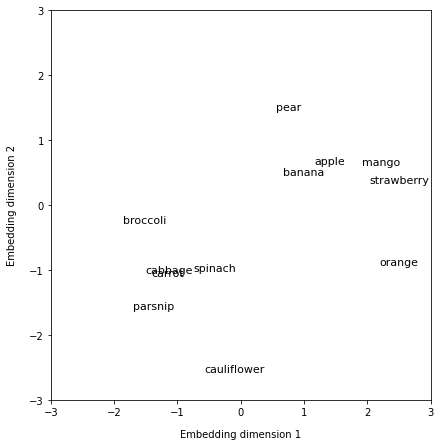

In [12]:
def plt_embedding(embedding, ax, xylim=(-3, 3),
                  xlab="Embedding dimension 1", 
                  ylab="Embedding dimension 2",
                  title=""):            
    sns.scatterplot(data=embedding, x="x", y ="y",
                    color="#ffffff", ax=ax)
    for i in range(embedding.shape[0]):
        ax.text(x=embedding["x"][i], y=embedding["y"][i], 
                s=embedding["id"][i], ha="center",
                fontdict=dict(size=11))    
    ax.set_xlabel(xlab, labelpad=12)
    ax.set_ylabel(ylab, labelpad=12)    
    ax.set_title(title)
    ax.set(xlim=xylim)
    ax.set(ylim=xylim)


fig, ax = plt.subplots(1, 1, figsize = (6, 6))
fig.tight_layout()
plt_embedding(embedding, ax)
plt.show()

The layout suggests a partition of the vocabulary into two primary groups. The labels reveal that the groups represent fruits and vegetables. Thus, the two-dimensional embedding captures semantic meaning of the vocabulary items.

## Expanding the vocabulary

Suppose that after some time, the dataset is updated to `produce_2.txt`.

In [13]:
produce_data2 = read_produce_data("produce_2.txt")
print(f"First data row:\t{produce_data2[0]}")
print(f"Dataset shape:\t{produce_data2.shape}")

First data row:	['apple' 'orange' 'banana']
Dataset shape:	(672, 3)


The dataset contains more tuples. It also contains a larger vocabulary of fruits and vegetables.

In [14]:
produce_vocabulary2 = sorted(set(produce_data2.flatten()))
new_produce = sorted(set(produce_vocabulary2).difference(produce_vocabulary))
produce_vocabulary2 = produce_vocabulary + new_produce
print(f"New vocabulary items:\t{new_produce}")
print(f"New vocabulary:\t{produce_vocabulary2}")
print(f"New vocabulary size:\t{len(produce_vocabulary2)}")

New vocabulary items:	['kiwi', 'lemon', 'pepper', 'pumpkin']
New vocabulary:	['apple', 'banana', 'broccoli', 'cabbage', 'carrot', 'cauliflower', 'mango', 'orange', 'parsnip', 'pear', 'spinach', 'strawberry', 'kiwi', 'lemon', 'pepper', 'pumpkin']
New vocabulary size:	16


The new vocabulary items are 'kiwi', 'lemon', 'pepper', and 'pumpkin'. These elements cannot be encoded into the low-dimensional space by our existing model. We must therefore train a new model. At first, let's try re-using our current training procedure on the new dataset.

In [15]:
# dataset and loader
produce_dataset2 = VocabDataset(produce_vocabulary2, produce_data2)
produce_loader2 = DataLoader(produce_dataset2, 
                             batch_size=4,
                             num_workers=n_cpus,
                             shuffle=True, 
                             drop_last=True)
# model
model2 = train_vocab_embedding(produce_loader2,                               
                               vocab_size=len(produce_dataset2.vocab))
embedding2 = make_embedding_table(produce_vocabulary2, model2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 32    
1 | output    | Linear           | 80    
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
112       Trainable params
0         Non-trainable params
112       Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

And we visualize the embedding.

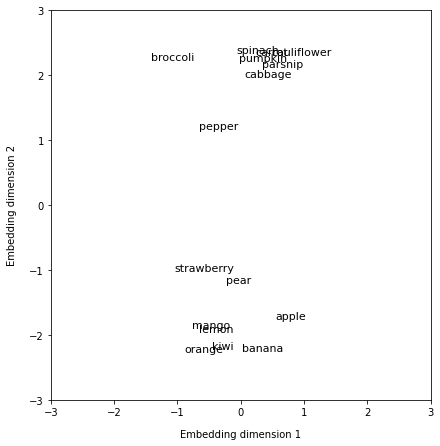

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
fig.tight_layout()
plt_embedding(embedding2, ax)
plt.show()

Qualitatively, this embedding again separates the fruits and vegetables. However, the coordinates are all different than before. This is problematic because any downstream applications that use the embedding coordinates must now also be updated. In particular, any machine-learning models that rely on the coordinates to make predictions must now be retrained with the new coordinates.

## Expanding an embedding with constraints

We would like to train a new embedding for the expanded vocabulary, but ensure that the previously-trained elements remain at the previously-defined coordinates. For this, we introduce a new training function.

In [17]:
def update_vocab_embedding(train_loader=None, epochs=10,
                           prev_model=None, **kwargs):
    model = VocabModule(**kwargs)
    constraint = EmbeddingConstraint(model.embedding, prev_model.embedding)
    trainer = pl.Trainer(gpus=0, 
                         max_epochs=epochs,
                         callbacks = [TQDMProgressBar(refresh_rate=5),
                                      constraint],
                         gradient_clip_val=5,
                         enable_progress_bar=False)    
    trainer.fit(model, train_loader)
    model.to(device)
    return model

The training function defines an `EmbeddingConstraint` object with two arguments. The first argument is the `Embedding` component in the new model. The second argument is a pre-existing embedding. The constraint is provided to the pytorch-lightning trainer as a callback. As the trainer will carry out training, the callback will maintain parts of the model embedding fixed.

We can now train a model with the new training function.

In [ ]:
model3 = update_vocab_embedding(produce_loader2, 
                                prev_model=model,
                                vocab_size=len(produce_dataset2.vocab))
embedding3 = make_embedding_table(produce_vocabulary2, model3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | embedding | Embedding        | 32    
1 | output    | Linear           | 80    
2 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
112       Trainable params
0         Non-trainable params
112       Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Finally, we can visualize the result. For ease of comparison, the first plot below reproduces the first embedding, and the second plot shows the new version.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
fig.tight_layout()
plt_embedding(embedding, ax[0], title="Original vocabulary")
plt_embedding(embedding3, ax[1], ylab="", title="Expanded vocabulary")
plt.show()

The original set of fruits and vegetables are located at exactly the same positions in the new embedding as in the original version. The new elements are placed at reasonable locations within the layour, for example, 'kiwi' is placed nearby other fruits.

## Conclusion

This notebook demonstrated how to adjust an embedding to accomodate an expanding vocabulary. The approach uses an `EmbeddingContraint` callback within a pytorch-lightning trainer.